### Plot Pairwise Correlations for Spheroid Aggregated data

In [1]:
import pandas as pd
import numpy as np
import os

from matplotlib.patches import Patch
from sklearn.metrics.pairwise import cosine_similarity

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("white")

# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1')
print(os.getcwd())

/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1/3_Figure4/PairwiseCorrelations
/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1


In [2]:
# Save the data
ImagesOut = '3_Figure4/PairwiseCorrelations/result-images/'

if not os.path.exists(ImagesOut): 
        os.makedirs(ImagesOut)

In [3]:
# Set up the plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
dpi = 300
figformat = 'pdf'

In [4]:
cell_line = 'HT29'
data_type = '2D'

In [5]:
# Load the data
dir = '1_Data/results/'
data =  pd.read_parquet(('{}grit_data_{}_{}.parquet').format(dir, data_type, cell_line))
data.dropna(axis='columns', how='all', inplace=True)

In [6]:
# Some function definitions

def list_features(df):
    # List features
    list_of_selected_features = list(df.columns.values)
    list_of_metadata = list(df.columns[df.columns.str.contains("Metadata_")])
    list_of_selected_features = list(set(list_of_selected_features) - set(list_of_metadata))
    
    return list_of_selected_features, list_of_metadata

def analyze_pathways(dataset, filter_criteria="Metadata_grit > 1.96", 
    correlation_method='cosine'):
    
    # Prepare and filter the dataset
    t = dataset.copy()
    meta = t[list_features(t)[1]]
    t = t.query('Metadata_pert_type == "trt"')
    t = t.groupby('Metadata_pert_name').median(numeric_only=True)
    t.drop(['Metadata_cmpd_conc'], axis=1, inplace=True)
    t = t.query(filter_criteria)
    data = t[list_features(t)[0]]

    # Calculate similarity matrix
    if correlation_method == 'pearson':
        # Use correlation
        sim_matrix = data.T.corr()
        sim_name = 'cor'
    elif correlation_method == 'cosine':
        # Use cosine similarity
        sim_matrix = pd.DataFrame(
            cosine_similarity(data),
            index=data.T.columns, columns=data.T.columns
        )
        sim_name = 'cosine_sim'
    else:
        raise ValueError("Invalid correlation_method. Use 'pearson' or 'cosine'.")

    # Reshape and map compound names
    m = sim_matrix.stack().to_frame(name=sim_name).reset_index(names=['pert_x', 'pert_y'])
    pert_to_name = dict(zip(meta.Metadata_pert_name, meta.Metadata_name))
    m['name_x'] = m['pert_x'].map(pert_to_name)
    m['name_y'] = m['pert_y'].map(pert_to_name)
    similarity_pivot_table = pd.pivot_table(m, values=sim_name, index='name_y', columns='name_x', aggfunc='max')

    return similarity_pivot_table

def calculate_similar_pairs(similarity_pivot_table):
    # Exclude diagonal elements
    p_no_diag = similarity_pivot_table.copy()
    np.fill_diagonal(p_no_diag.values, np.nan)

    # Convert to long format
    similarities = p_no_diag.unstack().reset_index()
    similarities.columns = ['Drug1', 'Drug2', 'Similarity']

    # Clean up the dataframe
    similarities['Pair'] = similarities.apply(
        lambda row: tuple(sorted([row['Drug1'], row['Drug2']])), axis=1)
    similarities = similarities.drop_duplicates(subset='Pair')
    similarities = similarities.dropna(subset=['Similarity'])
    similarities = similarities.sort_values(by='Similarity', ascending=False)

    return similarities


### Pairwise Correlations

In [7]:
## Prepare the metadata for the Pairwise calculation
dataset_pw  = data.copy()

# Create a dictionary of pathways and their associated compounds.
compounds = dataset_pw['Metadata_name'].unique()
pathways_dict = {cmpd: dataset_pw[dataset_pw['Metadata_name'] == cmpd]['Metadata_pathway'].unique()[0] for cmpd in compounds}
pathways = pd.Series(['MAPK','Cell Cycle', 'DNA Damage', 
                      'PI3K/Akt/mTOR', 'Epigenetics', 'Stem Cells & Wnt', 
                      'Angiogenesis', 'Protein Tyrosine Kinase', 
                      'Apoptosis', 'JAK/STAT', 'Cytoskeletal Signaling', 
                      'TGF-beta/Smad', 'Others', 'Proteases'])

# Create a color map for the pathways
colors = sns.color_palette('tab20', len(pathways))
lut = dict(zip(pathways, colors))
col_colors = pd.Series(pathways_dict).map(lut)
col_colors = col_colors.dropna()


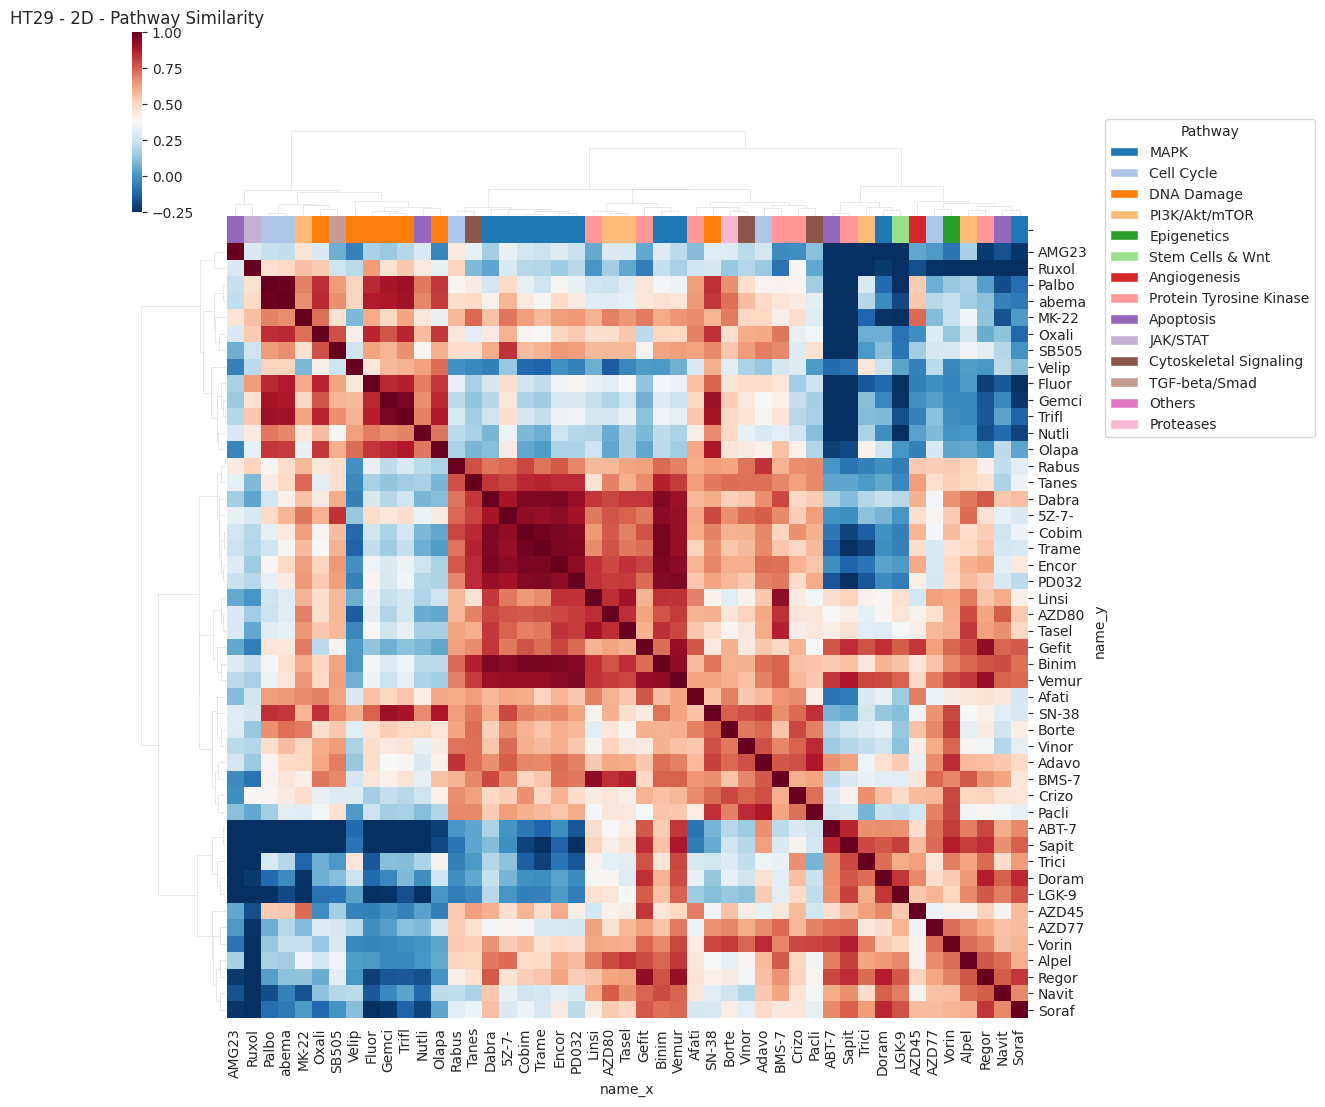

<Figure size 640x480 with 0 Axes>

In [8]:
# Calculate the similarity matrix
similarity_pivot_table = analyze_pathways(dataset_pw, filter_criteria="Metadata_grit > 1.96", correlation_method='cosine')

# Plot the clustermap
ax1 = sns.clustermap(
    similarity_pivot_table,
    cmap='RdBu_r',
    xticklabels=1,
    yticklabels=1,
    cbar_pos=(0.01, 0.9, 0.01, 0.18),
    tree_kws=dict(colors='#ddd'),
    cbar_kws=dict(shrink=0.2),
    method='ward',
    dendrogram_ratio=0.1,
    col_colors=col_colors,
    vmin = -0.25,
    vmax = 1
)

# Add legend
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Pathway',
            bbox_to_anchor=(1.2, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.title(f'{cell_line} - {data_type} - Pathway Similarity')

plt.show()

plt.savefig("{}/PairwiseCorrelations_{}_{}.{}".format(ImagesOut, cell_line, data_type, figformat), dpi=dpi, bbox_inches="tight"
            )

In [9]:
# List the most similar pairs
similarities = calculate_similar_pairs(similarity_pivot_table)

# Display the top 10 most similar pairs
top_10_similar_pairs = similarities.head(10)
print(("Top 10 most similar pairs for {}_{}:").format(cell_line, data_type))
print(top_10_similar_pairs[['Drug1', 'Drug2', 'Similarity']])

Top 10 most similar pairs for HT29_2D:
      Drug1  Drug2  Similarity
1409  Palbo  abema    0.987858
603   Cobim  Trame    0.979305
482   Binim  Cobim    0.974015
509   Binim  Trame    0.972038
934   Gemci  Trifl    0.970058
580   Cobim  Encor    0.967645
791   Encor  Trame    0.966413
674   Dabra  Encor    0.964167
486   Binim  Encor    0.963950
484   Binim  Dabra    0.959478


### Now compare 2D & 3D

In [21]:
dir = '1_Data/results/'

cell_line = 'HT29' # 'HCT116' or 'HT29'
data_types = ['2D', 'aggregates']

In [22]:
# Set up a dictionary
sim = {}

for data_type in data_types:
    data =  pd.read_parquet(('{}grit_data_{}_{}.parquet').format(dir, data_type, cell_line))
    data.dropna(axis='columns', how='all', inplace=True)
    
    sim[data_type] = calculate_similar_pairs(analyze_pathways(data))
    sim[data_type].sort_values(by=['Drug1', 'Drug2'], ascending=True, inplace=True)
    sim[data_type]['Pair'] = sim[data_type].apply(lambda row: tuple(sorted([row['Drug1'], row['Drug2']])), axis=1)

# Match the pairs in 2D with those in 3D
sim2D = sim['2D'].copy()
sim3D = sim['aggregates'].copy()

# Merge the two dataframes on the Pair column
sim2D['Match'] = sim2D['Pair'].isin(sim3D['Pair'])
similarities = sim2D.merge(sim3D, on=['Pair', 'Drug1', 'Drug2'], how='inner', suffixes=('_2D', '_3D'))

similarities['difference'] = similarities['Similarity_3D'] - similarities['Similarity_2D']
similarities['max'] = similarities[['Similarity_2D', 'Similarity_3D']].max(axis=1)

# Similarity_3D - Similarity_2D
differences = similarities['difference']

# Identify the 2.5% (lower) and 97.5% (upper) quantiles
lower_thresh = differences.quantile(0.025)
upper_thresh = differences.quantile(0.975)

# Mark whether each difference is in the extreme 5% region
similarities['tail'] = (
    (differences < lower_thresh) |
    (differences > upper_thresh)
)


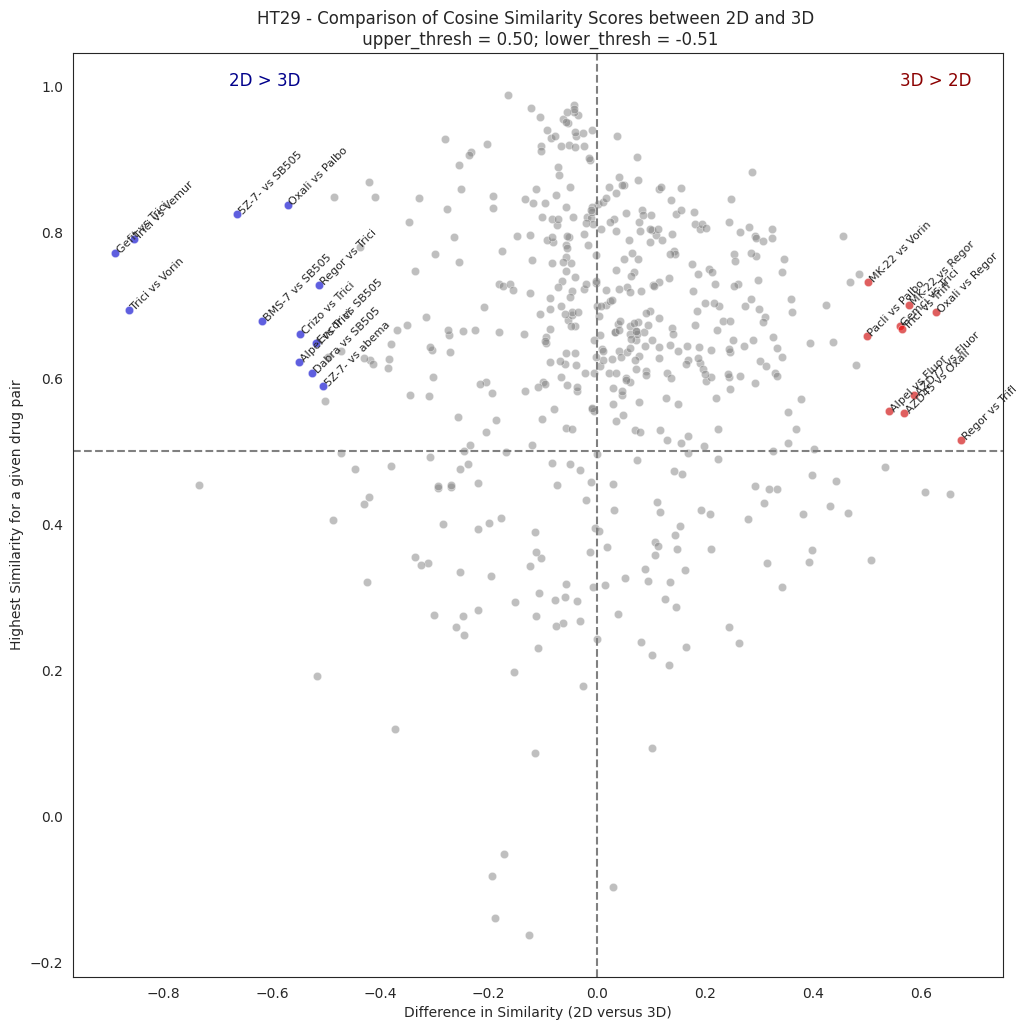

<Figure size 640x480 with 0 Axes>

In [23]:
## Plot the differences in a scatterplot

subset = similarities.query('tail == True & max > 0.5')

plt.figure(figsize=(12, 12))
sns.scatterplot(data=similarities, x='difference', y='max', c='gray', alpha=0.5)

sns.scatterplot(data=subset.query('difference < 0 '), x='difference', y='max', c='blue', alpha=0.5)
sns.scatterplot(data=subset.query('difference > 0 '), x='difference', y='max', c='red', alpha=0.5)

# The annotation are overlapping, so we can try to spread them out
for i, row in subset.iterrows():
    text = f"{row['Pair'][0]} vs {row['Pair'][1]}"
    plt.text(row['difference'], row['max'],text, fontsize=8, rotation=45)


plt.axhline(0.5, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Difference in Similarity (2D versus 3D)')
plt.ylabel('Highest Similarity for a given drug pair')
plt.title(f'{cell_line} - Comparison of Cosine Similarity Scores between 2D and 3D \n upper_thresh = {upper_thresh:.2f}; lower_thresh = {lower_thresh:.2f}')

# Add text to the plot
plt.text(-0.68, 1, '2D > 3D', color='darkblue', fontsize=12) # Left: 2D > 3D
plt.text(0.56, 1, '3D > 2D', color='darkred', fontsize=12) # Right: 3D > 2D

plt.show()

# Save the plot
plt.savefig("{}/Difference_{}_colored_tails.{}".format(ImagesOut, cell_line, figformat), dpi=dpi, bbox_inches="tight")
